# Day x
batch size 256 lr 1e-3, normed weighted, non-rotated, cartesian, SWA renwal test

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
#os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5562635219539179621
]


## Options

In [3]:
classTrainFeatures = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']
classModel = 'modelSwish'
varSet = "basic_features"

nSplits = 10
ensembleSize = 10
ensembleMode = 'loss'

maxEpochs = 200
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':classModel, 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs, 'mode':'classifier'}

print("\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(dirLoc + 'inputPipe.pkl', 'rb') as fin:
    inputPipe = pickle.load(fin)

In [5]:
trainData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'train.hdf5', "r+"),
                                    inputPipe=inputPipe, augRotMult=16)

## Determine LR

2 classes found, running in binary mode


______________________________________
Training finished
Cross-validation took 1.637s 


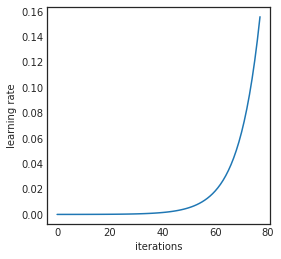

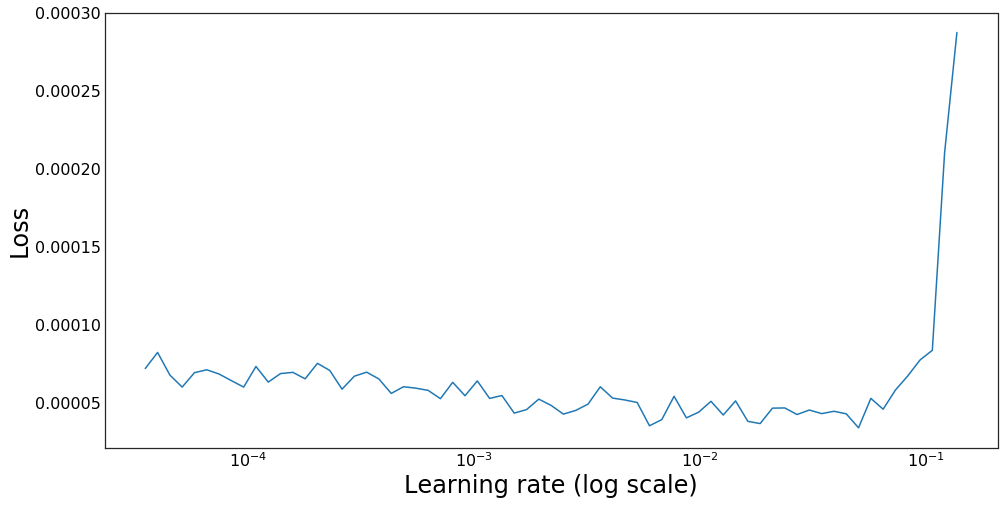

______________________________________



In [6]:
lrFinder = batchLRFind(trainData, getModel, modelParams, trainParams,
                       lrBounds=[1e-5,2e-1], trainOnWeights=True, verbose=0)

In [7]:
compileArgs['lr'] = 1e-3

In [8]:
def _batchTrainClassifier(batchYielder, nSplits, modelGen, modelGenParams, trainParams,
                         cosAnnealMult=0, reverseAnneal=False, plotLR=False, reduxDecay=False,
                         annealMomentum=False, reverseAnnealMomentum=False, plotMomentum=False,
                         oneCycle=False, ratio=0.25, reverse=False, lrScale=10, momScale=0.1, plotOneCycle=False, scale=30, mode='sgd',
                         swaStart=-1, swaRenewal=-1, sgdReplacement=False,
                         trainOnWeights=True,
                         saveLoc='train_weights/', patience=10, maxEpochs=10000,
                         verbose=False, logoutput=False):
    
    os.system("mkdir " + saveLoc)
    os.system("rm " + saveLoc + "*.h5")
    os.system("rm " + saveLoc + "*.json")
    os.system("rm " + saveLoc + "*.pkl")
    os.system("rm " + saveLoc + "*.png")
    os.system("rm " + saveLoc + "*.log")
    
    if logoutput:
        old_stdout = sys.stdout
        log_file = open(saveLoc + 'training_log.log', 'w')
        sys.stdout = log_file

    start = timeit.default_timer()
    results = []
    histories = []
    binary = None

    if not isinstance(batchYielder, BatchYielder):
        print ("HDF5 as input is depreciated, converting to BatchYielder")
        batchYielder = BatchYielder(batchYielder)

    if cosAnnealMult: print ("Using cosine annealing")
    if trainOnWeights: print ("Training using weights")

    for fold in range(nSplits):
        foldStart = timeit.default_timer()
        print ("Running fold", fold+1, "/", nSplits)
        os.system("rm " + saveLoc + "best.h5")
        best = -1
        bestLR = -1
        reduxDecayActive = False
        tmpPatience = patience
        epochCounter = 0
        subEpoch = 0
        stop = False
        lossHistory = {'val_loss':[], 'swa_val_loss':[]}
        trainID, testID = getFolds(fold, nSplits) #Get fold indeces for training and testing for current fold

        model = None
        model = modelGen(**modelGenParams)
        model.reset_states #Just checking
        
        testbatch = batchYielder.getBatch(testID) #Load testing fold

        callbacks = []
        if cosAnnealMult:
            cosAnneal = CosAnneal(math.ceil(len(batchYielder.source['fold_0/targets'])/trainParams['batch_size']), cosAnnealMult, reverseAnneal)
            callbacks.append(cosAnneal)
        
        if annealMomentum:
            cosAnnealMomentum = CosAnnealMomentum(math.ceil(len(batchYielder.source['fold_0/targets'])/trainParams['batch_size']), cosAnnealMult, reverseAnnealMomentum)
            callbacks.append(cosAnnealMomentum)    

        if oneCycle:
            oneCycle = OneCycle(math.ceil(len(batchYielder.source['fold_0/targets'])/trainParams['batch_size']), ratio=ratio, reverse=reverse, lrScale=lrScale, momScale=momScale, scale=scale, mode=mode)
            callbacks.append(oneCycle)  
        
        if swaStart >= 0:
            if cosAnnealMult:
                swa = _SWA(swaStart, testbatch, modelGen(**modelGenParams), verbose, swaRenewal, cosAnneal, trainOnWeights=trainOnWeights, sgdReplacement=sgdReplacement)
            else:
                swa = _SWA(swaStart, testbatch, modelGen(**modelGenParams), verbose, swaRenewal, trainOnWeights=trainOnWeights, sgdReplacement=sgdReplacement)
            callbacks.append(swa)
        useSWA = False

        for epoch in range(maxEpochs):
            for n in trainID: #Loop through training folds
                trainbatch = batchYielder.getBatch(n) #Load fold data
                subEpoch += 1
                
                if binary == None: #First run, check classification mode
                    binary = True
                    nClasses = len(np.unique(trainbatch['targets']))
                    if nClasses > 2:
                        print (nClasses, "classes found, running in multiclass mode\n")
                        trainbatch['targets'] = utils.to_categorical(trainbatch['targets'], num_classes=nClasses)
                        binary = False
                    else:
                        print (nClasses, "classes found, running in binary mode\n")

                if trainOnWeights:
                    model.fit(trainbatch['inputs'], trainbatch['targets'],
                              class_weight = 'auto', sample_weight=trainbatch['weights'],
                              callbacks = callbacks, **trainParams) #Train for one epoch

                    if swaStart >= 0 and swa.active:
                        losses = swa.get_losses()
                        print('{} swa loss {}, default loss {}'.format(subEpoch, losses['swa'], losses['base']))
                        if losses['swa'] < losses['base']:
                            loss = losses['swa']
                            useSWA = True
                        else:
                            loss = losses['base']
                            useSWA = False
                        
                    else:
                        loss = model.evaluate(testbatch['inputs'], testbatch['targets'], sample_weight=testbatch['weights'], verbose=0)
                    
                else:
                    model.fit(trainbatch['inputs'], trainbatch['targets'],
                              class_weight = 'auto',
                              callbacks = callbacks, **trainParams) #Train for one epoch
                    
                    if swaStart >= 0 and swa.active:
                        losses = swa.get_losses()
                        print('{} swa loss {}, default loss {}'.format(subEpoch, losses['swa'], losses['base']))
                        if losses['swa'] < losses['base']:
                            loss = losses['swa']
                            useSWA = True
                        else:
                            loss = losses['base']
                            useSWA = False
                    else:
                        loss = model.evaluate(testbatch['inputs'], testbatch['targets'], verbose=0)
                
                if swaStart >= 0 and swa.active and cosAnnealMult > 1:
                    print ("{} SWA loss:", subEpoch, loss)
                
                if swaStart >= 0:
                    if swa.active:
                        lossHistory['swa_val_loss'].append(losses['swa'])
                        lossHistory['val_loss'].append(losses['base'])
                    else:
                        lossHistory['swa_val_loss'].append(loss)
                        lossHistory['val_loss'].append(loss)
                else:
                    lossHistory['val_loss'].append(loss)        

                if loss <= best or best < 0: #Save best
                    best = loss
                    if cosAnnealMult:
                        if cosAnneal.lrs[-1] > 0:
                            bestLR = cosAnneal.lrs[-1]
                        else:
                            bestLR = cosAnneal.lrs[-2]
                    epochCounter = 0
                    if swaStart >= 0 and swa.active and useSWA:
                        swa.test_model.save_weights(saveLoc + "best.h5")
                    else:
                        model.save_weights(saveLoc + "best.h5")
                    if reduxDecayActive:
                        cosAnneal.lrs.append(float(K.get_value(model.optimizer.lr)))
                    if verbose:
                        print ('{} New best found: {}'.format(subEpoch, best))
                elif cosAnnealMult and not reduxDecayActive:
                    if cosAnneal.cycle_end:
                        epochCounter += 1
                else:
                    epochCounter += 1
                    if reduxDecayActive:
                        lr = 0.8*float(K.get_value(model.optimizer.lr))
                        cosAnneal.lrs.append(lr)
                        K.set_value(model.optimizer.lr, lr)

                if epochCounter >= tmpPatience: #Early stopping
                    if cosAnnealMult and reduxDecay and not reduxDecayActive:
                        print ('CosineAnneal stalling after {} epochs, entering redux decay at LR={}'.format(subEpoch, bestLR))
                        model.load_weights(saveLoc +  "best.h5")
                        cosAnneal.lrs.append(bestLR)
                        K.set_value(model.optimizer.lr, bestLR)
                        tmpPatience = 10
                        epochCounter = 0
                        callbacks = []
                        reduxDecayActive = True
                    else:
                        if verbose:
                            print ('Early stopping after {} epochs'.format(subEpoch))
                        stop = True
                        break
            
            if stop:
                break

        model.load_weights(saveLoc +  "best.h5")

        histories.append({})
        histories[-1]['val_loss'] = lossHistory['val_loss']
        if swaStart >= 0:
            histories[-1]['swa_val_loss'] = lossHistory['swa_val_loss']
        
        results.append({})
        results[-1]['loss'] = best
        if binary:
            testbatch = batchYielder.getBatch(testID) #Load testing fold
            if not isinstance(testbatch['weights'], type(None)):
                results[-1]['wAUC'] = 1-roc_auc_score(testbatch['targets'],
                                                     model.predict(testbatch['inputs'], verbose=0),
                                                     sample_weight=testbatch['weights'])
            results[-1]['AUC'] = 1-roc_auc_score(testbatch['targets'],
                                                 model.predict(testbatch['inputs'], verbose=0))
        print ("Score is:", results[-1])

        if plotLR: cosAnneal.plot_lr()
        if plotMomentum: cosAnnealMomentum.plot_momentum()
        if plotOneCycle: oneCycle.plot()

        print("Fold took {:.3f}s\n".format(timeit.default_timer() - foldStart))

        model.save(saveLoc +  'train_' + str(fold) + '.h5')
        with open(saveLoc +  'resultsFile.pkl', 'wb') as fout: #Save results
            pickle.dump(results, fout)

    print("\n______________________________________")
    print("Training finished")
    print("Cross-validation took {:.3f}s ".format(timeit.default_timer() - start))
    plotTrainingHistory(histories, save=saveLoc + 'loss_history.png')
    for score in results[0]:
        mean = uncertRound(np.mean([x[score] for x in results]), np.std([x[score] for x in results])/np.sqrt(len(results)))
        print ("Mean", score, "= {} +- {}".format(mean[0], mean[1]))
    print("______________________________________\n")
                      
    if logoutput:
        sys.stdout = old_stdout
        log_file.close()
    return results, histories

In [11]:
class _SWA(Callback):
    '''Based on fastai version'''
    def __init__(self, swa_start, testBatch, testModel, verbose=False, swaRenewal=-1,
                 clrCallback=None, trainOnWeights=False, sgdReplacement=False):
        super(_SWA, self).__init__()
        self.swa_model = None
        self.swa_model_new = None
        self.swa_start = swa_start
        self.epoch = -1
        self.swa_n = -1
        self.swaRenewal = swaRenewal
        self.n_since_renewal = -1
        self.losses = {'swa':None, 'base':None}
        self.active = False
        self.testBatch = testBatch
        self.weighted = trainOnWeights
        self.clrCallback = clrCallback
        self.test_model = testModel
        self.verbose = verbose
        self.sgdReplacement = sgdReplacement
        
    def on_train_begin(self, logs={}):
        if isinstance(self.swa_model, type(None)):
            self.swa_model = self.model.get_weights()
            self.swa_model_new = self.model.get_weights()
            self.epoch = 0
            self.swa_n = 0
            self.n_since_renewal = 0
            self.first_completed= False
            self.cylcle_since_replacement = 1
            
    def on_epoch_begin(self, metrics, logs={}):
        self.losses = {'swa':None, 'base':None}

    def on_epoch_end(self, metrics, logs={}):
        if (self.epoch + 1) >= self.swa_start and (isinstance(self.clrCallback, type(None)) or self.clrCallback.cycle_end):
            if self.swa_n == 0 and not self.active:
                print ("SWA beginning")
                self.active = True
            elif not isinstance(self.clrCallback, type(None)) and self.clrCallback.cycle_mult > 1:
                print ("Updating average")
                self.active = True
            self.update_average_model()
            self.swa_n += 1
            
            if self.swa_n > self.swaRenewal:
                self.first_completed = True
                self.n_since_renewal += 1
                if self.n_since_renewal > self.cylcle_since_replacement*self.swaRenewal and self.swaRenewal > 0:
                    self.compareAverages()
            
        if isinstance(self.clrCallback, type(None)) or self.clrCallback.cycle_end:
            self.epoch += 1

        if self.active and not (isinstance(self.clrCallback, type(None)) or self.clrCallback.cycle_end or self.clrCallback.cycle_mult == 1):
            self.active = False
            
    def update_average_model(self):
        # update running average of parameters
        print("model is {} epochs old".format(self.swa_n))
        for model_param, swa_param in zip(self.model.get_weights(), self.swa_model):
            swa_param *= self.swa_n
            swa_param += model_param
            swa_param /= (self.swa_n + 1)
        
        if self.swa_n > self.swaRenewal and self.first_completed:
            print("new model is {} epochs old".format(self.n_since_renewal))
            for model_param, swa_param in zip(self.model.get_weights(), self.swa_model_new):
                swa_param *= self.n_since_renewal
                swa_param += model_param
                swa_param /= (self.n_since_renewal + 1)
            
    def compareAverages(self):
        if isinstance(self.losses['swa'], type(None)):
            self.test_model.set_weights(self.swa_model)
            if self.weighted:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
            else:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        self.test_model.set_weights(self.swa_model_new)
        if self.weighted:
            new_loss = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
        else:
            new_loss = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        print("Checking renewal swa model, current model: {}, new model: {}".format(self.losses['swa'], new_loss))
        if new_loss < self.losses['swa']:
            print("New model better, replacing\n____________________\n\n")
            self.losses['swa'] = new_loss
            self.swa_n = self.n_since_renewal
            if self.sgdReplacement:
                if isinstance(self.losses['base'], type(None)):
                    if self.weighted:
                        self.losses['base'] = self.model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
                    else:
                        self.losses['base'] = self.model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
                if self.losses['base'] > new_loss:
                    print("Old average better than current point, starting SGD from old average")
                    self.model.set_weights(self.swa_model)
                    self.n_since_renewal = 0
                else:
                    print("Old average worse than current point, resuming SGD from current point")
                    self.n_since_renewal = 1
            else:
                self.n_since_renewal = 1
            self.swa_model[:] = self.swa_model_new
            self.swa_model_new = self.model.get_weights()
            self.cylcle_since_replacement = 1

        else:
            print("Current model better, renewing\n____________________\n\n")
            self.swa_model_new = self.model.get_weights()
            self.n_since_renewal = 1
            self.test_model.set_weights(self.swa_model)
            self.cylcle_since_replacement += 1
                
    
    def get_losses(self):
        if isinstance(self.losses['swa'], type(None)):
            self.test_model.set_weights(self.swa_model)
            if self.weighted:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
            else:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        if isinstance(self.losses['base'], type(None)):
            if self.weighted:
                self.losses['base'] = self.model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
            else:
                self.losses['base'] = self.model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        return self.losses

## Train classifier

Training using weights
Running fold 1 / 10
2 classes found, running in binary mode

1 New best found: 3.891715168533163e-05
2 New best found: 3.633845933149295e-05
3 New best found: 3.5655242642796646e-05
4 New best found: 3.5122112014410815e-05
5 New best found: 3.484730244333966e-05
6 New best found: 3.4767412740327445e-05
7 New best found: 3.4257114177950244e-05
9 New best found: 3.410467167659272e-05
10 New best found: 3.3915477510151554e-05
14 New best found: 3.337306688549824e-05
19 New best found: 3.3358978040391386e-05
20 New best found: 3.334261345771195e-05
21 New best found: 3.3153626740657195e-05
22 New best found: 3.307244474870867e-05
23 New best found: 3.305814081038699e-05
25 New best found: 3.3033774587339934e-05
26 New best found: 3.295516275214607e-05
27 New best found: 3.2870471537175946e-05
30 New best found: 3.273651236749796e-05
31 New best found: 3.27075532275801e-05
34 New best found: 3.256982422065243e-05
47 New best found: 3.252262144609082e-05
SWA beginning


model is 38 epochs old
new model is 12 epochs old
98 swa loss 3.1873954647039335e-05, default loss 3.236208620527546e-05
98 New best found: 3.1873954647039335e-05
model is 39 epochs old
new model is 13 epochs old
99 swa loss 3.1865638763564016e-05, default loss 3.2198150449102096e-05
99 New best found: 3.1865638763564016e-05
model is 40 epochs old
new model is 14 epochs old
100 swa loss 3.185872249694255e-05, default loss 3.205066513247102e-05
100 New best found: 3.185872249694255e-05
model is 41 epochs old
new model is 15 epochs old
Checking renewal swa model, current model: 3.185295052093515e-05, new model: 3.182163737623125e-05
New model better, replacing
____________________


Old average better than current point, starting SGD from old average
101 swa loss 3.182163737623125e-05, default loss 3.208490105206316e-05
101 New best found: 3.182163737623125e-05
model is 16 epochs old
new model is 0 epochs old
102 swa loss 3.181549608520633e-05, default loss 3.2064308113721375e-05
102 New

146 swa loss 3.16780547858931e-05, default loss 3.210711944497539e-05
146 New best found: 3.16780547858931e-05
model is 30 epochs old
new model is 9 epochs old
147 swa loss 3.1681818206677924e-05, default loss 3.2652922644149245e-05
model is 31 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.16752616027511e-05, new model: 3.168242679492859e-05
Current model better, renewing
____________________


148 swa loss 3.16752616027511e-05, default loss 3.1998657101925946e-05
148 New best found: 3.16752616027511e-05
model is 32 epochs old
new model is 1 epochs old
149 swa loss 3.167222845097981e-05, default loss 3.2256507745764207e-05
149 New best found: 3.167222845097981e-05
model is 33 epochs old
new model is 2 epochs old
150 swa loss 3.167091265738218e-05, default loss 3.2133765546240636e-05
150 New best found: 3.167091265738218e-05
model is 34 epochs old
new model is 3 epochs old
151 swa loss 3.166808569882197e-05, default loss 3.228275451114687e-05
151 New

model is 51 epochs old
new model is 5 epochs old
199 swa loss 3.159199662604192e-05, default loss 3.2097645474822566e-05
199 New best found: 3.159199662604192e-05
model is 52 epochs old
new model is 6 epochs old
200 swa loss 3.158983431123285e-05, default loss 3.2307364971469544e-05
200 New best found: 3.158983431123285e-05
model is 53 epochs old
new model is 7 epochs old
201 swa loss 3.158747123983766e-05, default loss 3.1951226222446245e-05
201 New best found: 3.158747123983766e-05
model is 54 epochs old
new model is 8 epochs old
202 swa loss 3.1583526786288973e-05, default loss 3.182324055700174e-05
202 New best found: 3.1583526786288973e-05
model is 55 epochs old
new model is 9 epochs old
203 swa loss 3.158242607266514e-05, default loss 3.2189747948292426e-05
203 New best found: 3.158242607266514e-05
model is 56 epochs old
new model is 10 epochs old
204 swa loss 3.158338633591218e-05, default loss 3.2104519917819344e-05
model is 57 epochs old
new model is 11 epochs old
205 swa loss

model is 58 epochs old
new model is 7 epochs old
252 swa loss 3.1498431425004766e-05, default loss 3.223338990979092e-05
model is 59 epochs old
new model is 8 epochs old
253 swa loss 3.150010958228736e-05, default loss 3.239949082330239e-05
model is 60 epochs old
new model is 9 epochs old
254 swa loss 3.150133481673338e-05, default loss 3.201751803706546e-05
model is 61 epochs old
new model is 10 epochs old
255 swa loss 3.1500691800492055e-05, default loss 3.197313963970894e-05
model is 62 epochs old
new model is 11 epochs old
256 swa loss 3.14993158599467e-05, default loss 3.193304433168337e-05
model is 63 epochs old
new model is 12 epochs old
257 swa loss 3.149918502409664e-05, default loss 3.204202912212805e-05
model is 64 epochs old
new model is 13 epochs old
258 swa loss 3.1500415917431335e-05, default loss 3.2032839826604914e-05
model is 65 epochs old
new model is 14 epochs old
259 swa loss 3.149961251419689e-05, default loss 3.19589612886353e-05
model is 66 epochs old
new model 

305 swa loss 3.1445161693685826e-05, default loss 3.197000469953504e-05
model is 41 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.1444775358308936e-05, new model: 3.152265194140237e-05
Current model better, renewing
____________________


306 swa loss 3.1444775358308936e-05, default loss 3.1898075291576364e-05
model is 42 epochs old
new model is 1 epochs old
307 swa loss 3.144722759456208e-05, default loss 3.206671209514692e-05
model is 43 epochs old
new model is 2 epochs old
308 swa loss 3.1446501555274706e-05, default loss 3.197608032362773e-05
model is 44 epochs old
new model is 3 epochs old
309 swa loss 3.144732664082748e-05, default loss 3.2144139353568604e-05
model is 45 epochs old
new model is 4 epochs old
310 swa loss 3.1446693910056216e-05, default loss 3.1961555172606307e-05
model is 46 epochs old
new model is 5 epochs old
311 swa loss 3.1447040583277935e-05, default loss 3.18811165520069e-05
model is 47 epochs old
new model is 6 epochs ol

364 swa loss 3.142783396635278e-05, default loss 3.186790555207802e-05
364 New best found: 3.142783396635278e-05
model is 100 epochs old
new model is 24 epochs old
365 swa loss 3.1427963922185664e-05, default loss 3.201297745302955e-05
model is 101 epochs old
new model is 25 epochs old
Checking renewal swa model, current model: 3.142991010225308e-05, new model: 3.1457507067105956e-05
Current model better, renewing
____________________


366 swa loss 3.142991010225308e-05, default loss 3.217820601836692e-05
model is 102 epochs old
new model is 1 epochs old
367 swa loss 3.142866164327314e-05, default loss 3.219060849449983e-05
model is 103 epochs old
new model is 2 epochs old
368 swa loss 3.1428626046867584e-05, default loss 3.197430225397428e-05
model is 104 epochs old
new model is 3 epochs old
369 swa loss 3.1428828427147415e-05, default loss 3.201303856882205e-05
model is 105 epochs old
new model is 4 epochs old
370 swa loss 3.142863000942598e-05, default loss 3.208856727957402e-05
mo

model is 156 epochs old
new model is 25 epochs old
421 swa loss 3.141688501480042e-05, default loss 3.1939168637146714e-05
421 New best found: 3.141688501480042e-05
model is 157 epochs old
new model is 26 epochs old
422 swa loss 3.1416421887454664e-05, default loss 3.214468696086114e-05
422 New best found: 3.1416421887454664e-05
model is 158 epochs old
new model is 27 epochs old
423 swa loss 3.141671139158375e-05, default loss 3.1876951453915564e-05
model is 159 epochs old
new model is 28 epochs old
424 swa loss 3.141659803891178e-05, default loss 3.204846295876448e-05
model is 160 epochs old
new model is 29 epochs old
425 swa loss 3.1416124667470214e-05, default loss 3.210389070877654e-05
425 New best found: 3.1416124667470214e-05
model is 161 epochs old
new model is 30 epochs old
426 swa loss 3.141600861706489e-05, default loss 3.197663728867537e-05
426 New best found: 3.141600861706489e-05
model is 162 epochs old
new model is 31 epochs old
427 swa loss 3.1415899264650825e-05, defaul

34 New best found: 3.30002391774226e-05
39 New best found: 3.291006589915346e-05
44 New best found: 3.2869872863947536e-05
47 New best found: 3.2663063759757614e-05
SWA beginning
model is 0 epochs old
50 swa loss 3.283687300019285e-05, default loss 3.283687300019285e-05
model is 1 epochs old
51 swa loss 3.279485624326432e-05, default loss 3.345353522368129e-05
model is 2 epochs old
52 swa loss 3.26829155466988e-05, default loss 3.28288176866057e-05
model is 3 epochs old
53 swa loss 3.265436974819586e-05, default loss 3.309422776086488e-05
53 New best found: 3.265436974819586e-05
model is 4 epochs old
54 swa loss 3.2546868519130634e-05, default loss 3.340046678810692e-05
54 New best found: 3.2546868519130634e-05
model is 5 epochs old
55 swa loss 3.254686636496372e-05, default loss 3.314315169592779e-05
55 New best found: 3.254686636496372e-05
model is 6 epochs old
new model is 1 epochs old
56 swa loss 3.248041492875522e-05, default loss 3.269298218369578e-05
56 New best found: 3.2480414

model is 39 epochs old
new model is 13 epochs old
99 swa loss 3.212034798711556e-05, default loss 3.26142124230596e-05
99 New best found: 3.212034798711556e-05
model is 40 epochs old
new model is 14 epochs old
100 swa loss 3.211567466193061e-05, default loss 3.2476472254308066e-05
100 New best found: 3.211567466193061e-05
model is 41 epochs old
new model is 15 epochs old
Checking renewal swa model, current model: 3.210990471299744e-05, new model: 3.2046520009845125e-05
New model better, replacing
____________________


Old average better than current point, starting SGD from old average
101 swa loss 3.2046520009845125e-05, default loss 3.2461509533700903e-05
101 New best found: 3.2046520009845125e-05
model is 16 epochs old
new model is 0 epochs old
102 swa loss 3.2043588204131715e-05, default loss 3.256104201271658e-05
102 New best found: 3.2043588204131715e-05
model is 17 epochs old
new model is 1 epochs old
103 swa loss 3.204101936415297e-05, default loss 3.287856332555379e-05
103 Ne

model is 62 epochs old
new model is 16 epochs old
148 swa loss 3.192617219681048e-05, default loss 3.249618700076709e-05
148 New best found: 3.192617219681048e-05
model is 63 epochs old
new model is 17 epochs old
149 swa loss 3.192240098328204e-05, default loss 3.234943414827294e-05
149 New best found: 3.192240098328204e-05
model is 64 epochs old
new model is 18 epochs old
150 swa loss 3.1920340497684274e-05, default loss 3.229256797262785e-05
150 New best found: 3.1920340497684274e-05
model is 65 epochs old
new model is 19 epochs old
151 swa loss 3.1919572848096314e-05, default loss 3.2904998977710966e-05
151 New best found: 3.1919572848096314e-05
model is 66 epochs old
new model is 20 epochs old
Checking renewal swa model, current model: 3.1918480766410374e-05, new model: 3.1902597476851855e-05
New model better, replacing
____________________


Old average better than current point, starting SGD from old average
152 swa loss 3.1902597476851855e-05, default loss 3.240810043501995e-05


model is 69 epochs old
new model is 18 epochs old
201 swa loss 3.1868774848521344e-05, default loss 3.260029461716838e-05
201 New best found: 3.1868774848521344e-05
model is 70 epochs old
new model is 19 epochs old
202 swa loss 3.186854490819829e-05, default loss 3.2331106415702245e-05
202 New best found: 3.186854490819829e-05
model is 71 epochs old
new model is 20 epochs old
Checking renewal swa model, current model: 3.1866517563203276e-05, new model: 3.187672948753393e-05
Current model better, renewing
____________________


203 swa loss 3.1866517563203276e-05, default loss 3.211211420334807e-05
203 New best found: 3.1866517563203276e-05
model is 72 epochs old
new model is 1 epochs old
204 swa loss 3.1866566696607144e-05, default loss 3.2307256134446044e-05
model is 73 epochs old
new model is 2 epochs old
205 swa loss 3.18661183764249e-05, default loss 3.2485754287673606e-05
205 New best found: 3.18661183764249e-05
model is 74 epochs old
new model is 3 epochs old
206 swa loss 3.18655

model is 123 epochs old
new model is 27 epochs old
255 swa loss 3.183702036166863e-05, default loss 3.24787858910557e-05
255 New best found: 3.183702036166863e-05
model is 124 epochs old
new model is 28 epochs old
256 swa loss 3.1836107215028005e-05, default loss 3.2455806077715745e-05
256 New best found: 3.1836107215028005e-05
model is 125 epochs old
new model is 29 epochs old
257 swa loss 3.1835963814210336e-05, default loss 3.245073231989793e-05
257 New best found: 3.1835963814210336e-05
model is 126 epochs old
new model is 30 epochs old
Checking renewal swa model, current model: 3.183538087298782e-05, new model: 3.187392415774255e-05
Current model better, renewing
____________________


258 swa loss 3.183538087298782e-05, default loss 3.225045486437355e-05
258 New best found: 3.183538087298782e-05
model is 127 epochs old
new model is 1 epochs old
259 swa loss 3.1834232858628213e-05, default loss 3.253355774246389e-05
259 New best found: 3.1834232858628213e-05
model is 128 epochs ol

model is 176 epochs old
new model is 15 epochs old
308 swa loss 3.181542737973602e-05, default loss 3.213142356558695e-05
model is 177 epochs old
new model is 16 epochs old
309 swa loss 3.1815264477780415e-05, default loss 3.236331432079127e-05
model is 178 epochs old
new model is 17 epochs old
310 swa loss 3.181459344839689e-05, default loss 3.221523478104094e-05
310 New best found: 3.181459344839689e-05
model is 179 epochs old
new model is 18 epochs old
311 swa loss 3.1814408309634595e-05, default loss 3.220556938003881e-05
311 New best found: 3.1814408309634595e-05
model is 180 epochs old
new model is 19 epochs old
312 swa loss 3.1814524751012145e-05, default loss 3.227465448635984e-05
model is 181 epochs old
new model is 20 epochs old
313 swa loss 3.181442367145984e-05, default loss 3.2455356686065897e-05
model is 182 epochs old
new model is 21 epochs old
314 swa loss 3.181455734467213e-05, default loss 3.2226710893685206e-05
model is 183 epochs old
new model is 22 epochs old
315 s

model is 239 epochs old
new model is 38 epochs old
371 swa loss 3.182231956778252e-05, default loss 3.253968268770772e-05
model is 240 epochs old
new model is 39 epochs old
372 swa loss 3.182308581868304e-05, default loss 3.260153776255478e-05
model is 241 epochs old
new model is 40 epochs old
373 swa loss 3.182354333530683e-05, default loss 3.26270684192374e-05
model is 242 epochs old
new model is 41 epochs old
374 swa loss 3.182358164994814e-05, default loss 3.244125615995619e-05
Early stopping after 374 epochs
Score is: {'loss': 3.1812369862583594e-05, 'wAUC': 0.0625611278389756, 'AUC': 0.09989671115286347}
Fold took 647.135s

Running fold 3 / 10
1 New best found: 4.045647705087282e-05
2 New best found: 3.746832930074312e-05
3 New best found: 3.635382649268284e-05
4 New best found: 3.565938550659596e-05
6 New best found: 3.5450457528726305e-05
7 New best found: 3.534821383624299e-05
8 New best found: 3.519003655773991e-05
9 New best found: 3.5071770503246285e-05
10 New best found: 3

model is 31 epochs old
new model is 5 epochs old
91 swa loss 3.274191433863366e-05, default loss 3.336959369181112e-05
model is 32 epochs old
new model is 6 epochs old
92 swa loss 3.2740283972737186e-05, default loss 3.344046192860785e-05
model is 33 epochs old
new model is 7 epochs old
93 swa loss 3.2739512536762515e-05, default loss 3.3290458651459146e-05
model is 34 epochs old
new model is 8 epochs old
94 swa loss 3.273361358650143e-05, default loss 3.290496683799679e-05
94 New best found: 3.273361358650143e-05
model is 35 epochs old
new model is 9 epochs old
95 swa loss 3.273036772542865e-05, default loss 3.311958290402516e-05
95 New best found: 3.273036772542865e-05
model is 36 epochs old
new model is 10 epochs old
96 swa loss 3.2727197465354086e-05, default loss 3.306988153729344e-05
96 New best found: 3.2727197465354086e-05
model is 37 epochs old
new model is 11 epochs old
97 swa loss 3.2727633045275576e-05, default loss 3.3420541594652374e-05
model is 38 epochs old
new model is

model is 25 epochs old
new model is 4 epochs old
142 swa loss 3.260990966494033e-05, default loss 3.312598558097596e-05
model is 26 epochs old
new model is 5 epochs old
143 swa loss 3.260599521709005e-05, default loss 3.3143910079974e-05
143 New best found: 3.260599521709005e-05
model is 27 epochs old
new model is 6 epochs old
144 swa loss 3.2602861305391135e-05, default loss 3.297693491237573e-05
144 New best found: 3.2602861305391135e-05
model is 28 epochs old
new model is 7 epochs old
145 swa loss 3.260578239952431e-05, default loss 3.3101835448287814e-05
model is 29 epochs old
new model is 8 epochs old
146 swa loss 3.260430331769939e-05, default loss 3.3164500529165766e-05
model is 30 epochs old
new model is 9 epochs old
147 swa loss 3.260465822128777e-05, default loss 3.3242714274699335e-05
model is 31 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.260544115975853e-05, new model: 3.264436280262897e-05
Current model better, renewing
_____________

model is 31 epochs old
new model is 5 epochs old
194 swa loss 3.254436230837484e-05, default loss 3.303271532699921e-05
model is 32 epochs old
new model is 6 epochs old
195 swa loss 3.2546311287093036e-05, default loss 3.32199758809492e-05
model is 33 epochs old
new model is 7 epochs old
196 swa loss 3.254319590651333e-05, default loss 3.289501436817496e-05
model is 34 epochs old
new model is 8 epochs old
197 swa loss 3.253956147510462e-05, default loss 3.290239344178869e-05
197 New best found: 3.253956147510462e-05
model is 35 epochs old
new model is 9 epochs old
198 swa loss 3.2537466256398464e-05, default loss 3.31743541448993e-05
198 New best found: 3.2537466256398464e-05
model is 36 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.253692342794581e-05, new model: 3.25680140610108e-05
Current model better, renewing
____________________


199 swa loss 3.253692342794581e-05, default loss 3.2894374054004636e-05
199 New best found: 3.253692342794581e-05

model is 35 epochs old
new model is 9 epochs old
249 swa loss 3.248318642825147e-05, default loss 3.319215627306325e-05
model is 36 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.2487714139133546e-05, new model: 3.256230334268161e-05
Current model better, renewing
____________________


250 swa loss 3.2487714139133546e-05, default loss 3.326704285797566e-05
model is 37 epochs old
new model is 1 epochs old
251 swa loss 3.24861710724801e-05, default loss 3.297743109507048e-05
model is 38 epochs old
new model is 2 epochs old
252 swa loss 3.2486044774676005e-05, default loss 3.305903563528831e-05
model is 39 epochs old
new model is 3 epochs old
253 swa loss 3.2488476388973996e-05, default loss 3.309232354269467e-05
model is 40 epochs old
new model is 4 epochs old
254 swa loss 3.2491235675036836e-05, default loss 3.3067491791444435e-05
model is 41 epochs old
new model is 5 epochs old
255 swa loss 3.248799619161888e-05, default loss 3.290817210431551e-05
m

310 swa loss 3.2473770241385686e-05, default loss 3.292574171161103e-05
model is 97 epochs old
new model is 1 epochs old
311 swa loss 3.2474993067570004e-05, default loss 3.307496564468941e-05
model is 98 epochs old
new model is 2 epochs old
312 swa loss 3.2475951569824744e-05, default loss 3.3181875325042585e-05
model is 99 epochs old
new model is 3 epochs old
313 swa loss 3.247756353852409e-05, default loss 3.322823158197009e-05
model is 100 epochs old
new model is 4 epochs old
314 swa loss 3.247626777252678e-05, default loss 3.281646570728972e-05
model is 101 epochs old
new model is 5 epochs old
315 swa loss 3.2474837012839174e-05, default loss 3.270867481053017e-05
model is 102 epochs old
new model is 6 epochs old
316 swa loss 3.247497255612332e-05, default loss 3.2978448116889456e-05
model is 103 epochs old
new model is 7 epochs old
317 swa loss 3.247657987454978e-05, default loss 3.341587520552679e-05
model is 104 epochs old
new model is 8 epochs old
318 swa loss 3.24765150438514

model is 159 epochs old
new model is 33 epochs old
373 swa loss 3.2467178362965916e-05, default loss 3.291074981326001e-05
model is 160 epochs old
new model is 34 epochs old
374 swa loss 3.246739950849999e-05, default loss 3.296215719089168e-05
model is 161 epochs old
new model is 35 epochs old
Checking renewal swa model, current model: 3.246839677859075e-05, new model: 3.258117586365838e-05
Current model better, renewing
____________________


375 swa loss 3.246839677859075e-05, default loss 3.329750100829648e-05
model is 162 epochs old
new model is 1 epochs old
376 swa loss 3.2468258198304644e-05, default loss 3.296128542283578e-05
model is 163 epochs old
new model is 2 epochs old
377 swa loss 3.246834730328922e-05, default loss 3.29756426697906e-05
model is 164 epochs old
new model is 3 epochs old
378 swa loss 3.246824425984676e-05, default loss 3.3264009646329205e-05
model is 165 epochs old
new model is 4 epochs old
379 swa loss 3.246913248637899e-05, default loss 3.324502072693882

70 swa loss 3.2186044663831125e-05, default loss 3.2610149585525506e-05
70 New best found: 3.2186044663831125e-05
model is 11 epochs old
new model is 0 epochs old
71 swa loss 3.219613453402417e-05, default loss 3.279012245620834e-05
model is 12 epochs old
new model is 1 epochs old
72 swa loss 3.219320630450966e-05, default loss 3.2899311266373846e-05
model is 13 epochs old
new model is 2 epochs old
73 swa loss 3.219515667587984e-05, default loss 3.3206184842856604e-05
model is 14 epochs old
new model is 3 epochs old
74 swa loss 3.219305931997951e-05, default loss 3.2717582595796555e-05
model is 15 epochs old
new model is 4 epochs old
75 swa loss 3.219362373201875e-05, default loss 3.268009125604294e-05
model is 16 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.218597930390388e-05, new model: 3.230298341659363e-05
Current model better, renewing
____________________


76 swa loss 3.218597930390388e-05, default loss 3.253864696162054e-05
76 New best foun

model is 30 epochs old
new model is 4 epochs old
122 swa loss 3.1970213673776014e-05, default loss 3.306226772692753e-05
model is 31 epochs old
new model is 5 epochs old
123 swa loss 3.1969996135740075e-05, default loss 3.2610155775910245e-05
model is 32 epochs old
new model is 6 epochs old
124 swa loss 3.1964914601121564e-05, default loss 3.2319311054016e-05
124 New best found: 3.1964914601121564e-05
model is 33 epochs old
new model is 7 epochs old
125 swa loss 3.196377856656909e-05, default loss 3.242283204308478e-05
125 New best found: 3.196377856656909e-05
model is 34 epochs old
new model is 8 epochs old
126 swa loss 3.1964485601929484e-05, default loss 3.244874707743293e-05
model is 35 epochs old
new model is 9 epochs old
127 swa loss 3.195785152347526e-05, default loss 3.214530612458475e-05
127 New best found: 3.195785152347526e-05
model is 36 epochs old
new model is 10 epochs old
128 swa loss 3.1953949373564684e-05, default loss 3.220315326179843e-05
128 New best found: 3.195394

173 swa loss 3.1862630682007874e-05, default loss 3.243872231469141e-05
173 New best found: 3.1862630682007874e-05
model is 56 epochs old
new model is 10 epochs old
174 swa loss 3.185894959460711e-05, default loss 3.236873437272152e-05
174 New best found: 3.185894959460711e-05
model is 57 epochs old
new model is 11 epochs old
175 swa loss 3.1856285143294374e-05, default loss 3.2338321906718195e-05
175 New best found: 3.1856285143294374e-05
model is 58 epochs old
new model is 12 epochs old
176 swa loss 3.185285673389444e-05, default loss 3.223339459655108e-05
176 New best found: 3.185285673389444e-05
model is 59 epochs old
new model is 13 epochs old
177 swa loss 3.185026205610484e-05, default loss 3.2294876038213264e-05
177 New best found: 3.185026205610484e-05
model is 60 epochs old
new model is 14 epochs old
178 swa loss 3.184871163975913e-05, default loss 3.236811342212605e-05
178 New best found: 3.184871163975913e-05
model is 61 epochs old
new model is 15 epochs old
179 swa loss 3.1

model is 62 epochs old
new model is 11 epochs old
226 swa loss 3.174229440628551e-05, default loss 3.201307513518259e-05
226 New best found: 3.174229440628551e-05
model is 63 epochs old
new model is 12 epochs old
227 swa loss 3.174029306101147e-05, default loss 3.2103128849121274e-05
227 New best found: 3.174029306101147e-05
model is 64 epochs old
new model is 13 epochs old
228 swa loss 3.173843496188056e-05, default loss 3.208762002759613e-05
228 New best found: 3.173843496188056e-05
model is 65 epochs old
new model is 14 epochs old
229 swa loss 3.1737845129100604e-05, default loss 3.2216630814946256e-05
229 New best found: 3.1737845129100604e-05
model is 66 epochs old
new model is 15 epochs old
230 swa loss 3.173617219290463e-05, default loss 3.215231617505197e-05
230 New best found: 3.173617219290463e-05
model is 67 epochs old
new model is 16 epochs old
231 swa loss 3.173614404367981e-05, default loss 3.220336374506587e-05
231 New best found: 3.173614404367981e-05
model is 68 epochs

model is 42 epochs old
new model is 1 epochs old
277 swa loss 3.168321471312083e-05, default loss 3.2231195115309675e-05
model is 43 epochs old
new model is 2 epochs old
278 swa loss 3.1685972324339674e-05, default loss 3.2306623374461194e-05
model is 44 epochs old
new model is 3 epochs old
279 swa loss 3.1682127229578326e-05, default loss 3.2029781020537484e-05
model is 45 epochs old
new model is 4 epochs old
280 swa loss 3.167998053540941e-05, default loss 3.21696506565786e-05
280 New best found: 3.167998053540941e-05
model is 46 epochs old
new model is 5 epochs old
281 swa loss 3.1679786976019385e-05, default loss 3.211657263454981e-05
281 New best found: 3.1679786976019385e-05
model is 47 epochs old
new model is 6 epochs old
282 swa loss 3.167942643485731e-05, default loss 3.2173079726635475e-05
282 New best found: 3.167942643485731e-05
model is 48 epochs old
new model is 7 epochs old
283 swa loss 3.167742372315843e-05, default loss 3.2253530924208465e-05
283 New best found: 3.1677

model is 102 epochs old
new model is 1 epochs old
337 swa loss 3.1672524294117464e-05, default loss 3.230192045593867e-05
model is 103 epochs old
new model is 2 epochs old
338 swa loss 3.167300000059185e-05, default loss 3.2325169038085734e-05
model is 104 epochs old
new model is 3 epochs old
339 swa loss 3.1674011507129764e-05, default loss 3.245005302596837e-05
model is 105 epochs old
new model is 4 epochs old
340 swa loss 3.167418345692568e-05, default loss 3.211244194826577e-05
model is 106 epochs old
new model is 5 epochs old
341 swa loss 3.167514009110164e-05, default loss 3.252503474213882e-05
model is 107 epochs old
new model is 6 epochs old
342 swa loss 3.167533742816886e-05, default loss 3.2115078887727575e-05
model is 108 epochs old
new model is 7 epochs old
343 swa loss 3.1674511040910146e-05, default loss 3.210677588504041e-05
model is 109 epochs old
new model is 8 epochs old
344 swa loss 3.1673894148843827e-05, default loss 3.204586036736146e-05
model is 110 epochs old
ne

65 swa loss 3.353825848462293e-05, default loss 3.4202926032594406e-05
65 New best found: 3.353825848462293e-05
model is 16 epochs old
new model is 6 epochs old
66 swa loss 3.35265528774471e-05, default loss 3.4018235733674373e-05
66 New best found: 3.35265528774471e-05
model is 17 epochs old
new model is 7 epochs old
67 swa loss 3.351413959026104e-05, default loss 3.386594082403463e-05
67 New best found: 3.351413959026104e-05
model is 18 epochs old
new model is 8 epochs old
68 swa loss 3.3501482955762184e-05, default loss 3.3762973548437e-05
68 New best found: 3.3501482955762184e-05
model is 19 epochs old
new model is 9 epochs old
69 swa loss 3.349038574669976e-05, default loss 3.3755333893350324e-05
69 New best found: 3.349038574669976e-05
model is 20 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.3478876561275686e-05, new model: 3.342444112349767e-05
New model better, replacing
____________________


Old average better than current point, starting

model is 40 epochs old
new model is 14 epochs old
116 swa loss 3.327913134708069e-05, default loss 3.3903680561343205e-05
model is 41 epochs old
new model is 15 epochs old
Checking renewal swa model, current model: 3.328066512476653e-05, new model: 3.3273045830719636e-05
New model better, replacing
____________________


Old average better than current point, starting SGD from old average
117 swa loss 3.3273045830719636e-05, default loss 3.435432540863985e-05
117 New best found: 3.3273045830719636e-05
model is 16 epochs old
new model is 0 epochs old
118 swa loss 3.327721823006869e-05, default loss 3.4043298313918055e-05
model is 17 epochs old
new model is 1 epochs old
119 swa loss 3.326438569347374e-05, default loss 3.3812011382542553e-05
119 New best found: 3.326438569347374e-05
model is 18 epochs old
new model is 2 epochs old
120 swa loss 3.327167951647425e-05, default loss 3.4192246268503366e-05
model is 19 epochs old
new model is 3 epochs old
121 swa loss 3.327970071259188e-05, def

Old average better than current point, starting SGD from old average
168 swa loss 3.32025098890881e-05, default loss 3.346197632345138e-05
168 New best found: 3.32025098890881e-05
model is 21 epochs old
new model is 0 epochs old
169 swa loss 3.3206080419768115e-05, default loss 3.3855674118967726e-05
model is 22 epochs old
new model is 1 epochs old
170 swa loss 3.321029921062291e-05, default loss 3.3678355463780466e-05
model is 23 epochs old
new model is 2 epochs old
171 swa loss 3.32048867319827e-05, default loss 3.359831271227449e-05
model is 24 epochs old
new model is 3 epochs old
172 swa loss 3.31997378350934e-05, default loss 3.362820010588621e-05
172 New best found: 3.31997378350934e-05
model is 25 epochs old
new model is 4 epochs old
173 swa loss 3.319768962392118e-05, default loss 3.3786694932496176e-05
173 New best found: 3.319768962392118e-05
model is 26 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.320026050350862e-05, new model: 3.3295244

224 swa loss 3.3158134981931655e-05, default loss 3.363361128140241e-05
224 New best found: 3.3158134981931655e-05
model is 77 epochs old
new model is 6 epochs old
225 swa loss 3.3155466995958705e-05, default loss 3.357925402087858e-05
225 New best found: 3.3155466995958705e-05
model is 78 epochs old
new model is 7 epochs old
226 swa loss 3.315596813627053e-05, default loss 3.3965742867439984e-05
model is 79 epochs old
new model is 8 epochs old
227 swa loss 3.315364578593289e-05, default loss 3.3572420247946864e-05
227 New best found: 3.315364578593289e-05
model is 80 epochs old
new model is 9 epochs old
228 swa loss 3.3154253952670844e-05, default loss 3.375945810548728e-05
model is 81 epochs old
new model is 10 epochs old
229 swa loss 3.3154066662245895e-05, default loss 3.373990913387388e-05
model is 82 epochs old
new model is 11 epochs old
230 swa loss 3.315284857962979e-05, default loss 3.350404740922386e-05
230 New best found: 3.315284857962979e-05
model is 83 epochs old
new mode

model is 33 epochs old
new model is 2 epochs old
277 swa loss 3.305160329764476e-05, default loss 3.33186762072728e-05
277 New best found: 3.305160329764476e-05
model is 34 epochs old
new model is 3 epochs old
278 swa loss 3.3052399325242735e-05, default loss 3.348859953257488e-05
model is 35 epochs old
new model is 4 epochs old
279 swa loss 3.30576341599226e-05, default loss 3.4105503305909224e-05
model is 36 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.306159118656069e-05, new model: 3.3207519010466056e-05
Current model better, renewing
____________________


280 swa loss 3.306159118656069e-05, default loss 3.380499111663085e-05
model is 37 epochs old
new model is 1 epochs old
281 swa loss 3.3058001261088064e-05, default loss 3.350423776282696e-05
model is 38 epochs old
new model is 2 epochs old
282 swa loss 3.3053675065457354e-05, default loss 3.343629568989854e-05
model is 39 epochs old
new model is 3 epochs old
283 swa loss 3.30546034310828e-05

53 swa loss 3.280211443343433e-05, default loss 3.322503890522057e-05
53 New best found: 3.280211443343433e-05
model is 4 epochs old
54 swa loss 3.278968886879739e-05, default loss 3.319832097477047e-05
54 New best found: 3.278968886879739e-05
model is 5 epochs old
55 swa loss 3.2748471599188634e-05, default loss 3.3012487112137025e-05
55 New best found: 3.2748471599188634e-05
model is 6 epochs old
new model is 1 epochs old
56 swa loss 3.2712953390728216e-05, default loss 3.3039547115913595e-05
56 New best found: 3.2712953390728216e-05
model is 7 epochs old
new model is 2 epochs old
57 swa loss 3.2690522211487405e-05, default loss 3.3082883567840325e-05
57 New best found: 3.2690522211487405e-05
model is 8 epochs old
new model is 3 epochs old
58 swa loss 3.2677496031101324e-05, default loss 3.304140650143381e-05
58 New best found: 3.2677496031101324e-05
model is 9 epochs old
new model is 4 epochs old
59 swa loss 3.265702604840044e-05, default loss 3.298387315153377e-05
59 New best found

101 swa loss 3.231006959249498e-05, default loss 3.279930869175587e-05
101 New best found: 3.231006959249498e-05
model is 26 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.2305659883422776e-05, new model: 3.2330882055975965e-05
Current model better, renewing
____________________


102 swa loss 3.2305659883422776e-05, default loss 3.282350695662899e-05
102 New best found: 3.2305659883422776e-05
model is 27 epochs old
new model is 1 epochs old
103 swa loss 3.2306232451810505e-05, default loss 3.285120602813549e-05
model is 28 epochs old
new model is 2 epochs old
104 swa loss 3.230369963130215e-05, default loss 3.2694682692817875e-05
104 New best found: 3.230369963130215e-05
model is 29 epochs old
new model is 3 epochs old
105 swa loss 3.229922660684679e-05, default loss 3.2917611437733286e-05
105 New best found: 3.229922660684679e-05
model is 30 epochs old
new model is 4 epochs old
106 swa loss 3.22956212767167e-05, default loss 3.270678082481027e-05
1

model is 35 epochs old
new model is 9 epochs old
152 swa loss 3.2180511129263324e-05, default loss 3.287182467320236e-05
model is 36 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.218411758134607e-05, new model: 3.236292917281389e-05
Current model better, renewing
____________________


153 swa loss 3.218411758134607e-05, default loss 3.2945012259006036e-05
model is 37 epochs old
new model is 1 epochs old
154 swa loss 3.218360804457916e-05, default loss 3.2668408819881735e-05
model is 38 epochs old
new model is 2 epochs old
155 swa loss 3.218585075228475e-05, default loss 3.270220825070282e-05
model is 39 epochs old
new model is 3 epochs old
156 swa loss 3.219073580548866e-05, default loss 3.3132876154559196e-05
model is 40 epochs old
new model is 4 epochs old
157 swa loss 3.2191232670447786e-05, default loss 3.259318741474999e-05
model is 41 epochs old
new model is 5 epochs old
158 swa loss 3.21906959041371e-05, default loss 3.270496865734458e-05
mo

206 swa loss 3.2117258074868006e-05, default loss 3.275559884932591e-05
206 New best found: 3.2117258074868006e-05
model is 39 epochs old
new model is 3 epochs old
207 swa loss 3.2119088573381304e-05, default loss 3.2777859094494485e-05
model is 40 epochs old
new model is 4 epochs old
208 swa loss 3.21160033083288e-05, default loss 3.260256616777042e-05
208 New best found: 3.21160033083288e-05
model is 41 epochs old
new model is 5 epochs old
209 swa loss 3.211523609352298e-05, default loss 3.2647298167285046e-05
209 New best found: 3.211523609352298e-05
model is 42 epochs old
new model is 6 epochs old
210 swa loss 3.211833695240784e-05, default loss 3.2918007412808945e-05
model is 43 epochs old
new model is 7 epochs old
211 swa loss 3.21162127846037e-05, default loss 3.251307475875364e-05
model is 44 epochs old
new model is 8 epochs old
212 swa loss 3.211660729139112e-05, default loss 3.2645381896873e-05
model is 45 epochs old
new model is 9 epochs old
213 swa loss 3.211507068772335e-0

model is 59 epochs old
new model is 13 epochs old
263 swa loss 3.206152570346603e-05, default loss 3.2478398544481024e-05
model is 60 epochs old
new model is 14 epochs old
264 swa loss 3.2062351147760635e-05, default loss 3.285793622781057e-05
model is 61 epochs old
new model is 15 epochs old
265 swa loss 3.206369151594117e-05, default loss 3.287511970702326e-05
model is 62 epochs old
new model is 16 epochs old
266 swa loss 3.2062227693677415e-05, default loss 3.251917235174915e-05
model is 63 epochs old
new model is 17 epochs old
267 swa loss 3.2060344745696056e-05, default loss 3.2371143727505116e-05
model is 64 epochs old
new model is 18 epochs old
268 swa loss 3.2057650369824844e-05, default loss 3.272333621862344e-05
model is 65 epochs old
new model is 19 epochs old
269 swa loss 3.205486746301176e-05, default loss 3.251394499529852e-05
model is 66 epochs old
new model is 20 epochs old
Checking renewal swa model, current model: 3.205410335358465e-05, new model: 3.211030469101388e-0

model is 19 epochs old
new model is 3 epochs old
79 swa loss 3.171703290281584e-05, default loss 3.258235764951678e-05
model is 20 epochs old
new model is 4 epochs old
80 swa loss 3.1720223791489844e-05, default loss 3.223862684390042e-05
model is 21 epochs old
new model is 5 epochs old
81 swa loss 3.17238999879919e-05, default loss 3.215078672656091e-05
model is 22 epochs old
new model is 6 epochs old
82 swa loss 3.1725644589459986e-05, default loss 3.2504206590238026e-05
model is 23 epochs old
new model is 7 epochs old
83 swa loss 3.1723123994015624e-05, default loss 3.2320683680882214e-05
model is 24 epochs old
new model is 8 epochs old
84 swa loss 3.171853413368808e-05, default loss 3.1973261854727755e-05
model is 25 epochs old
new model is 9 epochs old
85 swa loss 3.171642077650176e-05, default loss 3.2216108085413e-05
model is 26 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.171597539621871e-05, new model: 3.177701415261254e-05
Current model b

model is 46 epochs old
new model is 15 epochs old
Checking renewal swa model, current model: 3.159700576070463e-05, new model: 3.1578483943303584e-05
New model better, replacing
____________________


Old average better than current point, starting SGD from old average
132 swa loss 3.1578483943303584e-05, default loss 3.201729069260182e-05
132 New best found: 3.1578483943303584e-05
model is 16 epochs old
new model is 0 epochs old
133 swa loss 3.158004412252922e-05, default loss 3.2004624464025256e-05
model is 17 epochs old
new model is 1 epochs old
134 swa loss 3.1584514032874725e-05, default loss 3.215053134772461e-05
model is 18 epochs old
new model is 2 epochs old
135 swa loss 3.1581300985999404e-05, default loss 3.199803659372265e-05
model is 19 epochs old
new model is 3 epochs old
136 swa loss 3.157633704104228e-05, default loss 3.1966635957360265e-05
136 New best found: 3.157633704104228e-05
model is 20 epochs old
new model is 4 epochs old
137 swa loss 3.1571144255576654e-05, def

Old average better than current point, starting SGD from old average
183 swa loss 3.150590552540962e-05, default loss 3.188581842259737e-05
183 New best found: 3.150590552540962e-05
model is 21 epochs old
new model is 0 epochs old
184 swa loss 3.150637402432039e-05, default loss 3.208348877524259e-05
model is 22 epochs old
new model is 1 epochs old
185 swa loss 3.150368061469635e-05, default loss 3.223130389524158e-05
185 New best found: 3.150368061469635e-05
model is 23 epochs old
new model is 2 epochs old
186 swa loss 3.15003949785023e-05, default loss 3.226622367365053e-05
186 New best found: 3.15003949785023e-05
model is 24 epochs old
new model is 3 epochs old
187 swa loss 3.149956841225503e-05, default loss 3.192547076323535e-05
187 New best found: 3.149956841225503e-05
model is 25 epochs old
new model is 4 epochs old
188 swa loss 3.149431917263428e-05, default loss 3.194458445359487e-05
188 New best found: 3.149431917263428e-05
model is 26 epochs old
new model is 5 epochs old
Che

model is 73 epochs old
new model is 2 epochs old
236 swa loss 3.145580356067512e-05, default loss 3.188716321310494e-05
model is 74 epochs old
new model is 3 epochs old
237 swa loss 3.145482381660258e-05, default loss 3.19121279346291e-05
model is 75 epochs old
new model is 4 epochs old
238 swa loss 3.145515119394986e-05, default loss 3.212072018941399e-05
model is 76 epochs old
new model is 5 epochs old
239 swa loss 3.145450014708331e-05, default loss 3.2199400522222275e-05
model is 77 epochs old
new model is 6 epochs old
240 swa loss 3.1452184212685094e-05, default loss 3.1810697756009176e-05
240 New best found: 3.1452184212685094e-05
model is 78 epochs old
new model is 7 epochs old
241 swa loss 3.145245904161129e-05, default loss 3.1947461355593984e-05
model is 79 epochs old
new model is 8 epochs old
242 swa loss 3.145103315473534e-05, default loss 3.179300956544466e-05
242 New best found: 3.145103315473534e-05
model is 80 epochs old
new model is 9 epochs old
243 swa loss 3.14491438

Checking renewal swa model, current model: 3.142369837732986e-05, new model: 3.1478593210340474e-05
Current model better, renewing
____________________


290 swa loss 3.142369837732986e-05, default loss 3.211762344581075e-05
model is 57 epochs old
new model is 1 epochs old
291 swa loss 3.142327641544398e-05, default loss 3.1843033857876436e-05
model is 58 epochs old
new model is 2 epochs old
292 swa loss 3.142228940560017e-05, default loss 3.194782373757334e-05
model is 59 epochs old
new model is 3 epochs old
293 swa loss 3.142217721615452e-05, default loss 3.1870496047486085e-05
model is 60 epochs old
new model is 4 epochs old
294 swa loss 3.1420712858380283e-05, default loss 3.2056098460452634e-05
model is 61 epochs old
new model is 5 epochs old
295 swa loss 3.1422201496025084e-05, default loss 3.1933891295921055e-05
model is 62 epochs old
new model is 6 epochs old
296 swa loss 3.142416002374375e-05, default loss 3.2003724835522006e-05
model is 63 epochs old
new model is 7 epochs old

model is 9 epochs old
new model is 4 epochs old
59 swa loss 3.2050828072449145e-05, default loss 3.2349008763107215e-05
59 New best found: 3.2050828072449145e-05
model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.204206088369208e-05, new model: 3.2709545010542496e-05
Current model better, renewing
____________________


60 swa loss 3.204206088369208e-05, default loss 3.2583019471293335e-05
60 New best found: 3.204206088369208e-05
model is 11 epochs old
new model is 1 epochs old
61 swa loss 3.203634974547897e-05, default loss 3.274088599140902e-05
61 New best found: 3.203634974547897e-05
model is 12 epochs old
new model is 2 epochs old
62 swa loss 3.2029493068787854e-05, default loss 3.248962704905e-05
62 New best found: 3.2029493068787854e-05
model is 13 epochs old
new model is 3 epochs old
63 swa loss 3.203611466927157e-05, default loss 3.255298776505545e-05
model is 14 epochs old
new model is 4 epochs old
64 swa loss 3.2030300638234295e-05, 

model is 39 epochs old
new model is 8 epochs old
109 swa loss 3.182435190942537e-05, default loss 3.211553888088164e-05
109 New best found: 3.182435190942537e-05
model is 40 epochs old
new model is 9 epochs old
110 swa loss 3.1822451722186676e-05, default loss 3.226765622690539e-05
110 New best found: 3.1822451722186676e-05
model is 41 epochs old
new model is 10 epochs old
111 swa loss 3.1820418292132347e-05, default loss 3.2233858996677325e-05
111 New best found: 3.1820418292132347e-05
model is 42 epochs old
new model is 11 epochs old
112 swa loss 3.1819479917347e-05, default loss 3.2397444791206825e-05
112 New best found: 3.1819479917347e-05
model is 43 epochs old
new model is 12 epochs old
113 swa loss 3.181720478763179e-05, default loss 3.2223647031178195e-05
113 New best found: 3.181720478763179e-05
model is 44 epochs old
new model is 13 epochs old
114 swa loss 3.1816138930330675e-05, default loss 3.230052041170783e-05
114 New best found: 3.1816138930330675e-05
model is 45 epochs 

model is 44 epochs old
new model is 8 epochs old
160 swa loss 3.1698614718855775e-05, default loss 3.220239638054694e-05
model is 45 epochs old
new model is 9 epochs old
161 swa loss 3.16972948432635e-05, default loss 3.210510687405617e-05
model is 46 epochs old
new model is 10 epochs old
162 swa loss 3.169540031172754e-05, default loss 3.2143277418221086e-05
162 New best found: 3.169540031172754e-05
model is 47 epochs old
new model is 11 epochs old
163 swa loss 3.169684203086839e-05, default loss 3.212372431091386e-05
model is 48 epochs old
new model is 12 epochs old
164 swa loss 3.169632685876145e-05, default loss 3.2442960872081966e-05
model is 49 epochs old
new model is 13 epochs old
165 swa loss 3.169426093138226e-05, default loss 3.1964625616526196e-05
165 New best found: 3.169426093138226e-05
model is 50 epochs old
new model is 14 epochs old
166 swa loss 3.1693649114901224e-05, default loss 3.233208250579379e-05
166 New best found: 3.1693649114901224e-05
model is 51 epochs old
n

model is 43 epochs old
new model is 7 epochs old
210 swa loss 3.1602575842207725e-05, default loss 3.200533418335387e-05
model is 44 epochs old
new model is 8 epochs old
211 swa loss 3.160104337842515e-05, default loss 3.202098965168511e-05
model is 45 epochs old
new model is 9 epochs old
212 swa loss 3.159905949802782e-05, default loss 3.196133894188305e-05
model is 46 epochs old
new model is 10 epochs old
213 swa loss 3.159971708402592e-05, default loss 3.2185675629471116e-05
model is 47 epochs old
new model is 11 epochs old
214 swa loss 3.15967917275841e-05, default loss 3.186601572655592e-05
214 New best found: 3.15967917275841e-05
model is 48 epochs old
new model is 12 epochs old
215 swa loss 3.1598169311772594e-05, default loss 3.214842033239484e-05
model is 49 epochs old
new model is 13 epochs old
216 swa loss 3.159516715057469e-05, default loss 3.1939963684247304e-05
216 New best found: 3.159516715057469e-05
model is 50 epochs old
new model is 14 epochs old
217 swa loss 3.15946

265 swa loss 3.157238604860946e-05, default loss 3.212514479956786e-05
model is 99 epochs old
new model is 3 epochs old
266 swa loss 3.15704934106452e-05, default loss 3.188528204938704e-05
266 New best found: 3.15704934106452e-05
model is 100 epochs old
new model is 4 epochs old
267 swa loss 3.157108432098141e-05, default loss 3.21080934873014e-05
model is 101 epochs old
new model is 5 epochs old
268 swa loss 3.156963860241049e-05, default loss 3.185196998217011e-05
268 New best found: 3.156963860241049e-05
model is 102 epochs old
new model is 6 epochs old
269 swa loss 3.1569734208362566e-05, default loss 3.2184721641791925e-05
model is 103 epochs old
new model is 7 epochs old
270 swa loss 3.156977235338621e-05, default loss 3.208679625638897e-05
model is 104 epochs old
new model is 8 epochs old
271 swa loss 3.157065047950249e-05, default loss 3.2115624193203696e-05
model is 105 epochs old
new model is 9 epochs old
272 swa loss 3.1571333159896026e-05, default loss 3.2186201394082976e-

model is 161 epochs old
new model is 35 epochs old
Checking renewal swa model, current model: 3.156680754500246e-05, new model: 3.168241344856063e-05
Current model better, renewing
____________________


328 swa loss 3.156680754500246e-05, default loss 3.243944359444098e-05
model is 162 epochs old
new model is 1 epochs old
329 swa loss 3.156569942255164e-05, default loss 3.193629531115415e-05
model is 163 epochs old
new model is 2 epochs old
330 swa loss 3.156599013887899e-05, default loss 3.2277380604832125e-05
model is 164 epochs old
new model is 3 epochs old
331 swa loss 3.156573468251385e-05, default loss 3.2101382983812906e-05
model is 165 epochs old
new model is 4 epochs old
332 swa loss 3.1565912803224296e-05, default loss 3.228040383070771e-05
model is 166 epochs old
new model is 5 epochs old
333 swa loss 3.156599618022676e-05, default loss 3.227675546686181e-05
model is 167 epochs old
new model is 6 epochs old
334 swa loss 3.156550805939096e-05, default loss 3.209859189150939e

model is 16 epochs old
new model is 6 epochs old
66 swa loss 3.0776724263805266e-05, default loss 3.141840225373945e-05
model is 17 epochs old
new model is 7 epochs old
67 swa loss 3.074786452482723e-05, default loss 3.122913212673205e-05
67 New best found: 3.074786452482723e-05
model is 18 epochs old
new model is 8 epochs old
68 swa loss 3.075226559583839e-05, default loss 3.135494069110237e-05
model is 19 epochs old
new model is 9 epochs old
69 swa loss 3.0744929992580276e-05, default loss 3.113813360441624e-05
69 New best found: 3.0744929992580276e-05
model is 20 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.0746585108219776e-05, new model: 3.074495620743826e-05
New model better, replacing
____________________


Old average better than current point, starting SGD from old average
70 swa loss 3.074495620743826e-05, default loss 3.131721716019534e-05
model is 11 epochs old
new model is 0 epochs old
71 swa loss 3.074320141847396e-05, default loss 3.

model is 11 epochs old
new model is 0 epochs old
118 swa loss 3.059386601496145e-05, default loss 3.095843541949405e-05
118 New best found: 3.059386601496145e-05
model is 12 epochs old
new model is 1 epochs old
119 swa loss 3.0583501555410216e-05, default loss 3.08472174123485e-05
119 New best found: 3.0583501555410216e-05
model is 13 epochs old
new model is 2 epochs old
120 swa loss 3.0567141599641064e-05, default loss 3.101865054809221e-05
120 New best found: 3.0567141599641064e-05
model is 14 epochs old
new model is 3 epochs old
121 swa loss 3.055615569994608e-05, default loss 3.104617635417068e-05
121 New best found: 3.055615569994608e-05
model is 15 epochs old
new model is 4 epochs old
122 swa loss 3.0566918339361083e-05, default loss 3.129162692401473e-05
model is 16 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.058383098395046e-05, new model: 3.067916356135657e-05
Current model better, renewing
____________________


123 swa loss 3.05838309839

model is 41 epochs old
new model is 10 epochs old
174 swa loss 3.0487412488061247e-05, default loss 3.0804376073396225e-05
model is 42 epochs old
new model is 11 epochs old
175 swa loss 3.0483997102477373e-05, default loss 3.077339273427867e-05
model is 43 epochs old
new model is 12 epochs old
176 swa loss 3.0478724262399114e-05, default loss 3.0657989048879405e-05
176 New best found: 3.0478724262399114e-05
model is 44 epochs old
new model is 13 epochs old
177 swa loss 3.0477226527680138e-05, default loss 3.086236488211619e-05
177 New best found: 3.0477226527680138e-05
model is 45 epochs old
new model is 14 epochs old
178 swa loss 3.047484093521975e-05, default loss 3.079364680410084e-05
178 New best found: 3.047484093521975e-05
model is 46 epochs old
new model is 15 epochs old
Checking renewal swa model, current model: 3.0475654460608146e-05, new model: 3.047792594461346e-05
Current model better, renewing
____________________


179 swa loss 3.0475654460608146e-05, default loss 3.10629

model is 51 epochs old
new model is 15 epochs old
Checking renewal swa model, current model: 3.0398226561627246e-05, new model: 3.0395633802563658e-05
New model better, replacing
____________________


Old average better than current point, starting SGD from old average
230 swa loss 3.0395633802563658e-05, default loss 3.1082164936368096e-05
230 New best found: 3.0395633802563658e-05
model is 16 epochs old
new model is 0 epochs old
231 swa loss 3.0390495423357234e-05, default loss 3.078959459650256e-05
231 New best found: 3.0390495423357234e-05
model is 17 epochs old
new model is 1 epochs old
232 swa loss 3.0394553884589968e-05, default loss 3.0907518499315105e-05
model is 18 epochs old
new model is 2 epochs old
233 swa loss 3.039636669712425e-05, default loss 3.090922420176027e-05
model is 19 epochs old
new model is 3 epochs old
234 swa loss 3.0403199006870167e-05, default loss 3.095362411548362e-05
model is 20 epochs old
new model is 4 epochs old
235 swa loss 3.0409395196402878e-05, 

289 swa loss 3.0409284489173304e-05, default loss 3.098633689586309e-05
model is 75 epochs old
new model is 9 epochs old
290 swa loss 3.0410477625707958e-05, default loss 3.1053802660113047e-05
model is 76 epochs old
new model is 10 epochs old
291 swa loss 3.0409165571797402e-05, default loss 3.0707777927950474e-05
model is 77 epochs old
new model is 11 epochs old
292 swa loss 3.0407832285853773e-05, default loss 3.092872379981828e-05
model is 78 epochs old
new model is 12 epochs old
293 swa loss 3.040802655435865e-05, default loss 3.113440755319646e-05
model is 79 epochs old
new model is 13 epochs old
294 swa loss 3.0408680740950332e-05, default loss 3.097856800630938e-05
model is 80 epochs old
new model is 14 epochs old
295 swa loss 3.0410314145683857e-05, default loss 3.123586918051695e-05
model is 81 epochs old
new model is 15 epochs old
296 swa loss 3.0408721539739362e-05, default loss 3.085421899643518e-05
model is 82 epochs old
new model is 16 epochs old
297 swa loss 3.041048564

82 swa loss 3.1545032746103196e-05, default loss 3.188929634380345e-05
82 New best found: 3.1545032746103196e-05
model is 33 epochs old
new model is 13 epochs old
83 swa loss 3.153734726165673e-05, default loss 3.1858767909296276e-05
83 New best found: 3.153734726165673e-05
model is 34 epochs old
new model is 14 epochs old
84 swa loss 3.152910368262894e-05, default loss 3.2086280054955406e-05
84 New best found: 3.152910368262894e-05
model is 35 epochs old
new model is 15 epochs old
Checking renewal swa model, current model: 3.1519608036412094e-05, new model: 3.1506736964349585e-05
New model better, replacing
____________________


Old average better than current point, starting SGD from old average
85 swa loss 3.1506736964349585e-05, default loss 3.168352587732038e-05
85 New best found: 3.1506736964349585e-05
model is 16 epochs old
new model is 0 epochs old
86 swa loss 3.1509242341887205e-05, default loss 3.207475193697577e-05
model is 17 epochs old
new model is 1 epochs old
87 swa los

model is 40 epochs old
new model is 14 epochs old
131 swa loss 3.135895911837841e-05, default loss 3.175214622924549e-05
131 New best found: 3.135895911837841e-05
model is 41 epochs old
new model is 15 epochs old
Checking renewal swa model, current model: 3.1357485814636266e-05, new model: 3.131477182922697e-05
New model better, replacing
____________________


Old average better than current point, starting SGD from old average
132 swa loss 3.131477182922697e-05, default loss 3.1943148833468975e-05
132 New best found: 3.131477182922697e-05
model is 16 epochs old
new model is 0 epochs old
133 swa loss 3.132185515205234e-05, default loss 3.1931565897684666e-05
model is 17 epochs old
new model is 1 epochs old
134 swa loss 3.1319230544166036e-05, default loss 3.1756805709353035e-05
model is 18 epochs old
new model is 2 epochs old
135 swa loss 3.131990142172954e-05, default loss 3.1946688953938694e-05
model is 19 epochs old
new model is 3 epochs old
136 swa loss 3.1317987511439576e-05, def

model is 69 epochs old
new model is 3 epochs old
186 swa loss 3.12852839399725e-05, default loss 3.174458501709274e-05
186 New best found: 3.12852839399725e-05
model is 70 epochs old
new model is 4 epochs old
187 swa loss 3.128472843012245e-05, default loss 3.1731721810187973e-05
187 New best found: 3.128472843012245e-05
model is 71 epochs old
new model is 5 epochs old
188 swa loss 3.1283671876598775e-05, default loss 3.1567959673099076e-05
188 New best found: 3.1283671876598775e-05
model is 72 epochs old
new model is 6 epochs old
189 swa loss 3.1281243917847814e-05, default loss 3.1469018372973356e-05
189 New best found: 3.1281243917847814e-05
model is 73 epochs old
new model is 7 epochs old
190 swa loss 3.127999799623984e-05, default loss 3.170136466192444e-05
190 New best found: 3.127999799623984e-05
model is 74 epochs old
new model is 8 epochs old
191 swa loss 3.127752986437254e-05, default loss 3.160828153873289e-05
191 New best found: 3.127752986437254e-05
model is 75 epochs old


model is 55 epochs old
new model is 14 epochs old
238 swa loss 3.116184807232905e-05, default loss 3.178383842823347e-05
model is 56 epochs old
new model is 15 epochs old
Checking renewal swa model, current model: 3.115864692056652e-05, new model: 3.120820588452498e-05
Current model better, renewing
____________________


239 swa loss 3.115864692056652e-05, default loss 3.1556893629726e-05
model is 57 epochs old
new model is 1 epochs old
240 swa loss 3.116089048678178e-05, default loss 3.190371670041174e-05
model is 58 epochs old
new model is 2 epochs old
241 swa loss 3.116240284508774e-05, default loss 3.1963739165388665e-05
model is 59 epochs old
new model is 3 epochs old
242 swa loss 3.116318668117467e-05, default loss 3.163774136667185e-05
model is 60 epochs old
new model is 4 epochs old
243 swa loss 3.116270452392096e-05, default loss 3.166884736574124e-05
model is 61 epochs old
new model is 5 epochs old
244 swa loss 3.116185153494851e-05, default loss 3.16568568939262e-05
model i

298 swa loss 3.1144272991982385e-05, default loss 3.177815525547033e-05
model is 116 epochs old
new model is 15 epochs old
299 swa loss 3.114400197247524e-05, default loss 3.1647186842470536e-05
model is 117 epochs old
new model is 16 epochs old
300 swa loss 3.114346133669955e-05, default loss 3.174555706178215e-05
model is 118 epochs old
new model is 17 epochs old
301 swa loss 3.114360060349074e-05, default loss 3.181938935252137e-05
model is 119 epochs old
new model is 18 epochs old
302 swa loss 3.114116527928341e-05, default loss 3.147429362142306e-05
302 New best found: 3.114116527928341e-05
model is 120 epochs old
new model is 19 epochs old
303 swa loss 3.114018468837257e-05, default loss 3.165358766817471e-05
303 New best found: 3.114018468837257e-05
model is 121 epochs old
new model is 20 epochs old
304 swa loss 3.1139218520222257e-05, default loss 3.1664159609121e-05
304 New best found: 3.1139218520222257e-05
model is 122 epochs old
new model is 21 epochs old
305 swa loss 3.113

model is 172 epochs old
new model is 6 epochs old
355 swa loss 3.112725092261508e-05, default loss 3.182172964560601e-05
355 New best found: 3.112725092261508e-05
model is 173 epochs old
new model is 7 epochs old
356 swa loss 3.1126310902107735e-05, default loss 3.1659466023985375e-05
356 New best found: 3.1126310902107735e-05
model is 174 epochs old
new model is 8 epochs old
357 swa loss 3.112672138050095e-05, default loss 3.180077749441932e-05
model is 175 epochs old
new model is 9 epochs old
358 swa loss 3.1126801690170114e-05, default loss 3.1692733717920365e-05
model is 176 epochs old
new model is 10 epochs old
359 swa loss 3.112676314349352e-05, default loss 3.158037909752362e-05
model is 177 epochs old
new model is 11 epochs old
360 swa loss 3.1125790981291524e-05, default loss 3.1387449248059715e-05
360 New best found: 3.1125790981291524e-05
model is 178 epochs old
new model is 12 epochs old
361 swa loss 3.112561306086182e-05, default loss 3.171290443784437e-05
361 New best fou

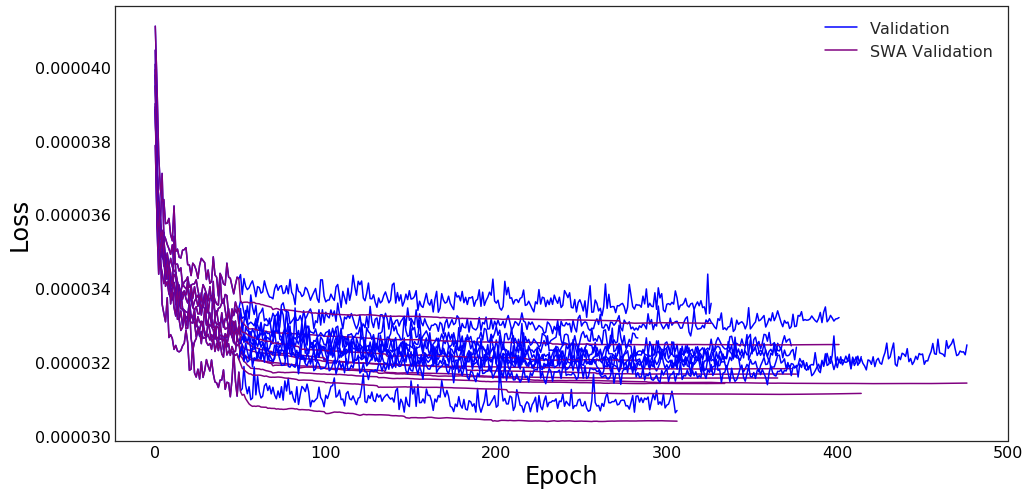

Mean loss = 3.17e-05 +- 2e-07
Mean wAUC = 0.063 +- 0.0009
Mean AUC = 0.0979 +- 0.0007
______________________________________



<Figure size 432x288 with 0 Axes>

In [14]:
results, histories = _batchTrainClassifier(trainData, nSplits, getModel, modelParams, trainParams, swaStart=50,
                                          patience=50, swaRenewal=5, sgdReplacement=True,
                                          trainOnWeights=True, cosAnnealMult=0, reduxDecay=False,
                                          maxEpochs=maxEpochs, verbose=1)

## Construct ensemble

In [21]:
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [ ]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs)

## Response on val data

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = False, reflect = True, augRotMult=16)

In [ ]:
pred = []
for i in xrange(10):
    tmpPred = []
    for aug in range(valData.augMult):
        batch = valData.getTestBatch(i, aug)['inputs']
        tmpPred.append(ensemblePredict(batch, ensemble, weights, n=1))
    pred.append(np.array(tmpPred))

In [ ]:
tPred = np.concatenate(pred, axis=1)

In [ ]:
df = pandas.DataFrame(getFeature('targets', valData.source), columns=['target'])

In [ ]:
for p in xrange(tPred.shape[0]):
    df['pred_'+ str(p)] = tPred[p,:]

In [ ]:
df.loc[:,'pred_mean'] = np.mean(df[[x for x in df.columns if 'pred' in x]], axis=1)

### Rot 8

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### Ref

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 4

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 8

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 10

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 16

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

In [ ]:
def amsScanQuick(inData, wFactor=250000./50000.):
    s = np.sum(inData.loc[inData['gen_target'] == 1, 'gen_weight'])
    b = np.sum(inData.loc[inData['gen_target'] == 0, 'gen_weight'])
    tIIs = inData['pred_class'].argsort()
    amss = np.empty([len(tIIs)])
    
    amsMax = 0
    threshold = 0.0

    for tI in range(len(tIIs)):
        # don't forget to renormalize the weights to the same sum 
        # as in the complete training set
        amss[tI] = AMS(max(0,s * wFactor),max(0,b * wFactor))
        if amss[tI] > amsMax:
            amsMax = amss[tI]
            threshold = inData['pred_class'].values[tIIs[tI]]
            #print tI,threshold
        if inData.loc[:, 'gen_target'].values[tIIs[tI]]:
            s -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
        else:
            b -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
    print amsMax, threshold
    return amsMax, threshold

## Response on validation data base

In [ ]:
valData = BatchYielder(h5py.File(dirLoc + 'val.hdf5', "r+"))

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 4

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=4)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 8

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Ref

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = False, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 4

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=4)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 5

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=5)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 6

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=6)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 8

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=10)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 16

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 16

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 3

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=3)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 5

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=5)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

# Final run

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8),
                     ensembleSize=5, verbose=1)

In [ ]:
saveTest(0.9632657, 'Day_10_basic_rotref8_5')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_basic_rotref8_5_test.csv -m"Day_10 basic rotref8 5"

## Response on validation data Rot-Ref 8 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
cut = amsScanQuick(convertToDF(valData.source))[1]

In [ ]:
trainFrame = pandas.DataFrame()
trainFrame['gen_target'] = getFeature('targets', trainData.source)
trainFrame['gen_weight'] = getFeature('weights', trainData.source)
valFrame = convertToDF(valData.source)

In [ ]:
sigFactor = (len(trainFrame.loc[trainFrame.gen_target == 1, 'gen_weight'])+len(valFrame.loc[valFrame.gen_target == 1, 'gen_weight']))/len(valFrame.loc[valFrame.gen_target == 1, 'gen_weight'])
bkgFactor = (len(trainFrame.loc[trainFrame.gen_target == 0, 'gen_weight'])+len(valFrame.loc[valFrame.gen_target == 0, 'gen_weight']))/len(valFrame.loc[valFrame.gen_target == 0, 'gen_weight'])
print sigFactor, bkgFactor

In [ ]:
def amsScanQuick(inData, sigFactor=250000./50000., bkgFactor=250000./50000.):
    s = np.sum(inData.loc[inData['gen_target'] == 1, 'gen_weight'])
    b = np.sum(inData.loc[inData['gen_target'] == 0, 'gen_weight'])
    tIIs = inData['pred_class'].argsort()
    amss = np.empty([len(tIIs)])
    
    amsMax = 0
    threshold = 0.0

    for tI in range(len(tIIs)):
        # don't forget to renormalize the weights to the same sum 
        # as in the complete training set
        amss[tI] = AMS(max(0,s * sigFactor),max(0,b * bkgFactor))
        if amss[tI] > amsMax:
            amsMax = amss[tI]
            threshold = inData['pred_class'].values[tIIs[tI]]
            #print tI,threshold
        if inData.loc[:, 'gen_target'].values[tIIs[tI]]:
            s -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
        else:
            b -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
    print amsMax, threshold
    return amsMax, threshold

In [ ]:
amsScanQuick(valFrame, sigFactor, bkgFactor)

In [ ]:
def amsScan(inData, scale=False):
    best = [0,-1]
    ams = []
    for index, row in inData.iterrows():
        s = wFactor*np.sum(inData.loc[(inData['pred_class'] >= row['pred_class']) & (inData['gen_target'] == 1), 'gen_weight'])
        b = wFactor*np.sum(inData.loc[(inData['pred_class'] >= row['pred_class']) & (inData['gen_target'] == 0), 'gen_weight'])
        ams.append(AMS(s, b))
        if ams[-1] > best[1]:
            best = [row['pred_class'], ams[-1]]
    print best
    return ams, best

def foldAMSScan(inData, N=10):
    kf = StratifiedKFold(n_splits=N, shuffle=True)
    folds = kf.split(inData, inData['gen_target'])
    bests = []
    for i, (train, test) in enumerate(folds):
        bests.append(amsScan(inData.iloc[test], (np.sum(inData[(inData['gen_target'] == 1)]['gen_weight']), np.sum(inData[(inData['gen_target'] == 0)]['gen_weight'])))[1])
        print "Fold {}, best AMS {} at cut of {}. Total weights Signal:Bkg. {}:{}".format(i, bests[-1][1], bests[-1][0],
                                                                                          np.sum(inData.iloc[test][inData.gen_target == 1]['gen_weight']),
                                                                                          np.sum(inData.iloc[test][inData.gen_target == 0]['gen_weight']))
    print "Mean cut", np.average([x[0] for x in bests], weights=[1/x[1] for x in bests]), "mean AMS", np.average([x[1] for x in bests], weights=[1/x[1] for x in bests])
    return bests

In [ ]:
amsScanQuick(convertToDF(valData.source), 1, 1)

In [ ]:
bests = foldAMSScan(convertToDF(valData.source))

In [ ]:
print np.average([x[0] for x in bests])
print np.average([x[0] for x in bests], weights=[1/x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[1.7448610687361392-x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[1/np.abs(1.7448610687361392-x[1]) for x in bests])

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8),
                     ensembleSize=10, verbose=1)

In [ ]:
saveTest(0.9557010754710975, 'Day_10_M_rotref8_10')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_M_rotref8_10_test.csv -m"Day_10 minus rotref8 10"

## Response on validation data Rot-Ref 16 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=1)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source), 1, 1)

In [ ]:
bests = foldAMSScan(convertToDF(valData.source))

In [ ]:
print 'Mean', np.average([x[0] for x in bests])
print 'Inverse-AMS-weighted mean', np.average([x[0] for x in bests], weights=[1/x[1] for x in bests])
print 'AMS-weighted mean', np.average([x[0] for x in bests], weights=[x[1] for x in bests])
print 'AMS-Difference-weighted mean', np.average([x[0] for x in bests], weights=[1.7472080023156094-x[1] for x in bests])
print 'Inverse AMS-Difference-weighted mean', np.average([x[0] for x in bests], weights=[1/np.abs(1.7472080023156094-x[1]) for x in bests])

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16),
                     ensembleSize=10, verbose=1)

In [ ]:
saveTest(0.95, 'Day_10_95_rotref16_10')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_95_rotref16_10_test.csv -m"Day_10 95 rotref16 10"